Model Definition

In [1]:
# import necessary packages
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tvt

import matplotlib.pyplot as plt
from utilities import *

from matplotlib.colors import LinearSegmentedColormap

from functools import reduce
from functools import partial

#   # Create a custom colormap that is inverted
cmap = plt.cm.viridis  # Choose the colormap you want to invert
cmap_inverted = LinearSegmentedColormap.from_list("inverted_viridis", cmap(np.linspace(1, 0, 256)))



from timeit import default_timer
import scipy.io
import os
import sys
from itertools import chain
import time


from scipy.io import loadmat
from astar.astar import  AStar
from astar.environment_simple import Environment3D


In [2]:
# Function Definitions

def tic():
  return time.time()

# def toc(tstart, nm=""):
#   print('%s took %s sec.\n' % (nm,(time.time() - tstart)))

def toc(tstart):
   return (time.time() - tstart)

# Helpers:

class ConstrainedLinear(nn.Linear):
  def forward(self, x):
    return F.linear(x, torch.min(self.weight ** 2, torch.abs(self.weight)))

# Activations:

class MaxReLUPairwiseActivation(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.weights = nn.Parameter(torch.zeros(1, num_features))
    self.avg_pool = nn.AvgPool1d(2, 2)

  def forward(self, x):
    x = x.unsqueeze(1)
    max_component = F.max_pool1d(x, 2)
    relu_component = F.avg_pool1d(F.relu(x * F.softplus(self.weights)), 2)
    output = torch.cat((max_component, relu_component), dim=-1).squeeze(1)
    return output


class MaxAvgGlobalActivation(nn.Module):
  def __init__(self):
    super().__init__()
    self.alpha = nn.Parameter(-torch.ones(1))

  def forward(self, x):
    alpha = torch.sigmoid(self.alpha)
    return alpha * x.max(dim=-1)[0] + (1 - alpha) * x.mean(dim=-1)


class MaxPoolPairwiseActivation(nn.Module):
  def forward(self, x):
    x = x.unsqueeze(1)
    x = F.max_pool1d(x, 2)
    return x.squeeze(1)


class ConcaveActivation(nn.Module):
  def __init__(self, num_features, concave_activation_size):
    super().__init__()
    assert concave_activation_size > 1

    self.bs_nonzero = nn.Parameter(1e-3 * torch.randn((1, num_features, concave_activation_size - 1)) - 1)
    self.bs_zero    = torch.zeros((1, num_features, 1))
    self.ms = nn.Parameter(1e-3 * torch.randn((1, num_features, concave_activation_size)))

  def forward(self, x):
    bs = torch.cat((F.softplus(self.bs_nonzero), self.bs_zero), -1)
    ms = 2 * torch.sigmoid(self.ms)
    x = x.unsqueeze(-1)

    x = x * ms + bs
    return x.min(-1)[0]


# Metrics:

class ReduceMetric(nn.Module):
  def __init__(self, mode):
    super().__init__()
    if mode == 'avg':
      self.forward = self.avg_forward
    elif mode == 'max':
      self.forward = self.max_forward
    elif mode == 'maxavg':
      self.maxavg_activation = MaxAvgGlobalActivation()
      self.forward = self.maxavg_forward
    else:
      raise NotImplementedError

  def maxavg_forward(self, x):
    return self.maxavg_activation(x)

  def max_forward(self, x):
    return x.max(-1)[0]

  def avg_forward(self, x):
    return x.mean(-1)


class DeepNormMetric(nn.Module):
  def __init__(self, num_features, layers, activation=nn.ReLU, concave_activation_size=None, mode='avg', symmetric=False):
    super().__init__()
    self.num_features = num_features

    assert len(layers) >= 2

    self.Us = nn.ModuleList([nn.Linear(num_features, layers[0], bias=False)])
    self.Ws = nn.ModuleList([])

    for in_features, out_features in zip(layers[:-1], layers[1:]):
      self.Us.append(nn.Linear(num_features, out_features, bias=False))
      self.Ws.append(ConstrainedLinear(in_features, out_features, bias=False))

    self.activation = activation()
    self.output_activation = ConcaveActivation(layers[-1], concave_activation_size) if concave_activation_size else nn.Identity()
    self.reduce_metric = ReduceMetric(mode)

    self.symmetric = symmetric

  def _asym_fwd(self, h):
    h1 = self.Us[0](h)
    for U, W in zip(self.Us[1:], self.Ws):
      h1 = self.activation(W(h1) + U(h))
    return h1

  def forward(self, x, y):
    h = x - y
    if self.symmetric:
      h = self._asym_fwd(h) + self._asym_fwd(-h)
    else:
      h = self._asym_fwd(-h)
    h = self.activation(h)
    return self.reduce_metric(h)


################################################################
# 3d fourier layers
################################################################

class SpectralConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2, modes3):
        super(SpectralConv3d, self).__init__()

        """
        3D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 
        self.modes2 = modes2
        self.modes3 = modes3

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights3 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights4 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul3d(self, input, weights):
        # (batch, in_channel, x,y,t ), (in_channel, out_channel, x,y,t) -> (batch, out_channel, x,y,t)
        return torch.einsum("bixyz,ioxyz->boxyz", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfftn(x, dim=[-3,-2,-1])

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-3), x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, :self.modes1, :self.modes2, :self.modes3], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, -self.modes1:, :self.modes2, :self.modes3], self.weights2)
        out_ft[:, :, :self.modes1, -self.modes2:, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, :self.modes1, -self.modes2:, :self.modes3], self.weights3)
        out_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3], self.weights4)

        #Return to physical space
        x = torch.fft.irfftn(out_ft, s=(x.size(-3), x.size(-2), x.size(-1)))
        return x


class PlanningOperator3D(nn.Module):
    def __init__(self, modes1, modes2, modes3, width, nlayers):
        super(PlanningOperator3D, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.modes3 = modes3
        self.width = width
        self.inp_size = 3
        self.nlayers = nlayers

        self.fc0 = nn.Linear(self.inp_size, self.width)
        for i in range(self.nlayers):
            self.add_module('conv%d' % i, SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3))
            self.add_module('w%d' % i, nn.Conv3d(self.width, self.width, 1))
        self.fc1 =  DeepNormMetric(self.width, (128, 128), concave_activation_size=20, activation=lambda: MaxReLUPairwiseActivation(128), symmetric=True)

    def forward(self, chi, gs):
        batchsize = chi.shape[0]
        size_x = size_y = size_z = chi.shape[1]

        grid = self.get_grid(batchsize, size_x, size_y, size_z, chi.device)

        chi = chi.permute(0, 4, 1, 2, 3)
        chi = chi.expand(batchsize, self.width, size_x, size_y, size_z)
        x = grid

        # Lifting layer:
        x = self.fc0(x)
        x = x.permute(0, 4, 1, 2, 3)

        for i in range(self.nlayers):
            conv_chi = self._modules['conv%d' % i](chi)
            conv_chix = self._modules['conv%d' % i](chi * x)
            xconv_chi = x * conv_chi
            wx = self._modules['w%d' % i](x)
            x = chi * (conv_chix - xconv_chi + wx)
            if i < self.nlayers - 1: x = F.gelu(x)

        x = x.permute(0, 2, 3, 4, 1)
        g = x.clone()

        for i in range(batchsize):
          g[i, :, :, :,:] = x[i, int(gs[i,0,0]), int(gs[i,1,0]), int(gs[i,2,0]), :]

        x = x.reshape(-1,self.width)
        g = g.reshape(-1,self.width)

        # Projection Layer
        output = self.fc1(x,g)
        output = output.reshape(batchsize,size_x,size_y,size_z,1)

        return output

    def get_grid(self, batchsize, size_x, size_y, size_z, device):
        gridx = torch.tensor(np.linspace(-1, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1, 1).repeat([batchsize, 1, size_y, size_z, 1])
        
        gridy = torch.tensor(np.linspace(-1, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1, 1).repeat([batchsize, size_x, 1, size_z, 1])
        
        gridz = torch.tensor(np.linspace(-1, 1, size_z), dtype=torch.float)
        gridz = gridz.reshape(1, 1, 1, size_z, 1).repeat([batchsize, size_x, size_y, 1, 1])
        
        return torch.cat((gridx, gridy, gridz), dim=-1).to(device)


def scheduler(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer


def LR_schedule(learning_rate, steps, scheduler_step, scheduler_gamma):
    return learning_rate * np.power(scheduler_gamma, (steps // scheduler_step))


def smooth_chi(mask, dist, smooth_coef):
    return torch.mul(torch.tanh(dist * smooth_coef), (mask - 0.5)) + 0.5


if __name__ == '__main__':
    # define hyperparameters
    lrs = [5e-3]
    gammas = [0.5]
    wds = [3e-6]
    smooth_coefs = [5.]
    smooth_coef = smooth_coefs[0]
    # experiments to be replicated with different seeds
    seeds = [5, 2000, 14000, 16000, 100000]
    seeds = [seeds[0]]

    ################################################################
    #                       configs
    ################################################################
    Ntotal = 1000*5+200*5
    ntrain = 1000*5
    ntest = Ntotal-ntrain

    batch_size = 1

    epochs = 501
    scheduler_step = 100
    tol_early_stop = 500

    modes = 8
    width = 32
    nlayers = 5

    ################################################################
    # load data and data normalization
    ################################################################
    t1 = default_timer()

    sub = 1
    Sx = int(((30 - 1) / sub) + 1)
    Sy = Sx
    Sz = Sx

    mask = np.load('./3d_dataset_30x30x30/mask.npy')
    mask = torch.tensor(mask, dtype=torch.float)
    dist_in = np.load('./3d_dataset_30x30x30/dist_in.npy')
    dist_in = torch.tensor(dist_in[:Ntotal, :, :], dtype=torch.float)
    input = smooth_chi(mask, dist_in, smooth_coef)
    output = np.load('./3d_dataset_30x30x30/output.npy')
    output = torch.tensor(output, dtype=torch.float)
    goals = np.load('./3d_dataset_30x30x30/goals.npy')
    goals = torch.tensor(goals, dtype=torch.float)


    mask_train = mask[:Ntotal][:ntrain, ::sub, ::sub, ::sub][:, :Sx, :Sy, :Sz]
    mask_test = mask[:Ntotal][-ntest:, ::sub, ::sub, ::sub][:, :Sx, :Sy, :Sz]

    mask_train = mask_train.reshape(ntrain, Sx, Sy, Sz, 1)
    mask_test = mask_test.reshape(ntest, Sx, Sy, Sz, 1)

    chi_train = input[:Ntotal][:ntrain, ::sub, ::sub, ::sub][:, :Sx, :Sy, :Sz]
    chi_test = input[:Ntotal][-ntest:, ::sub, ::sub, ::sub][:, :Sx, :Sy, :Sz]

    chi_train = chi_train.reshape(ntrain, Sx, Sy, Sz, 1)
    chi_test = chi_test.reshape(ntest, Sx, Sy, Sz,1)

    y_train = output[:Ntotal][:ntrain, ::sub, ::sub, ::sub][:, :Sx, :Sy, :Sz]
    y_test = output[:Ntotal][-ntest:, ::sub, ::sub, ::sub][:, :Sx, :Sy, :Sz]

    y_train = y_train.reshape(ntrain, Sx, Sy, Sz, 1)
    y_test = y_test.reshape(ntest, Sx, Sy, Sz, 1)

    goals_train = goals[:ntrain]
    goals_test = goals[-ntest:]

    goals_train = goals_train.reshape(ntrain, 3, 1)
    goals_test = goals_test.reshape(ntest, 3, 1)

    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(mask_test, chi_test, y_test, goals_test),
                                              batch_size=batch_size,
                                              shuffle=False)

Loading the trained Model

In [3]:
# Load the trained model
model = PlanningOperator3D(modes, modes, modes, width, nlayers)
model.load_state_dict(torch.load("planningoperator_3d_30x30x30_symmetric_norm/n5000_lr5.000000e-03_gamma5.000000e-01_wd3.000000e-06_seed5/model_depth4.ckpt"))
# model.load_state_dict(torch.load("planningoperator_3d_20x20x20_symmetric_norm/n10000_lr5.000000e-03_gamma5.000000e-01_wd3.000000e-06_seed5/model_depth4.ckpt"))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

PlanningOperator3D(
  (fc0): Linear(in_features=3, out_features=32, bias=True)
  (conv0): SpectralConv3d()
  (w0): Conv3d(32, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (conv1): SpectralConv3d()
  (w1): Conv3d(32, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (conv2): SpectralConv3d()
  (w2): Conv3d(32, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (conv3): SpectralConv3d()
  (w3): Conv3d(32, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (conv4): SpectralConv3d()
  (w4): Conv3d(32, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (fc1): DeepNormMetric(
    (Us): ModuleList(
      (0-1): 2 x Linear(in_features=32, out_features=128, bias=False)
    )
    (Ws): ModuleList(
      (0): ConstrainedLinear(in_features=128, out_features=128, bias=False)
    )
    (activation): MaxReLUPairwiseActivation(
      (avg_pool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    )
    (output_activation): ConcaveActivation()
    (reduce_metric): ReduceMetric()
  )
)

Plot predicted and ground truth

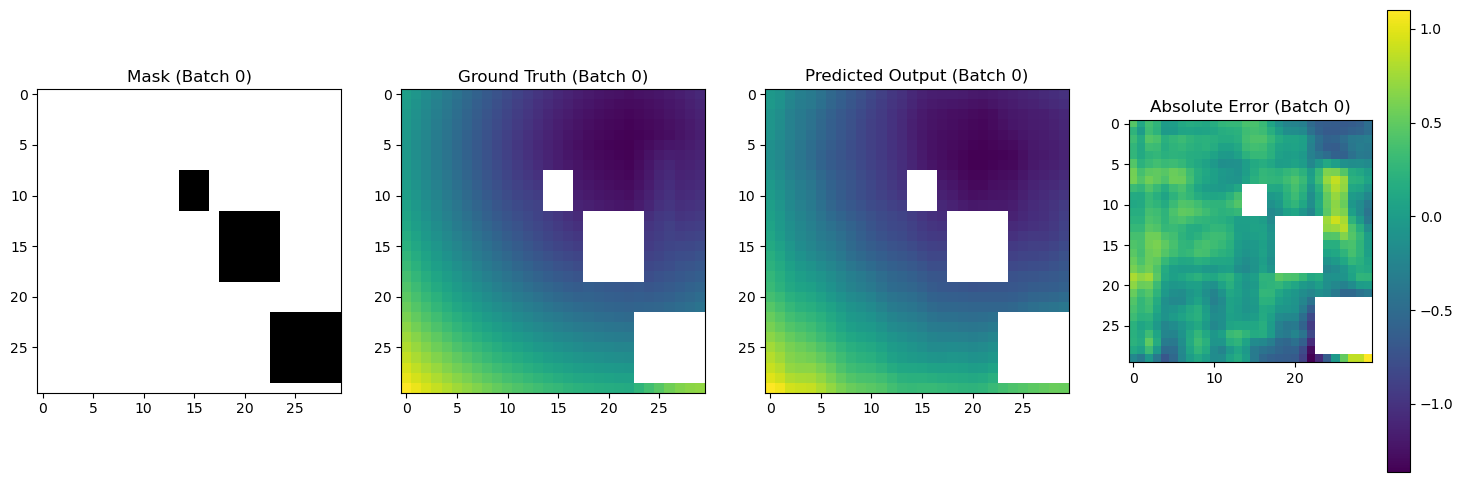

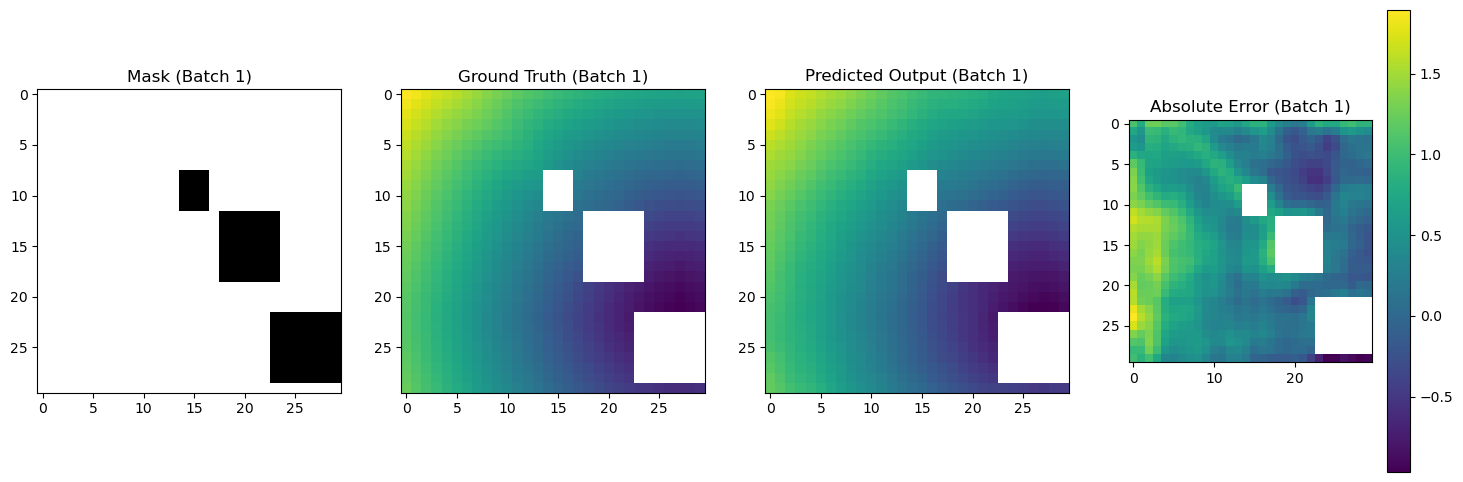

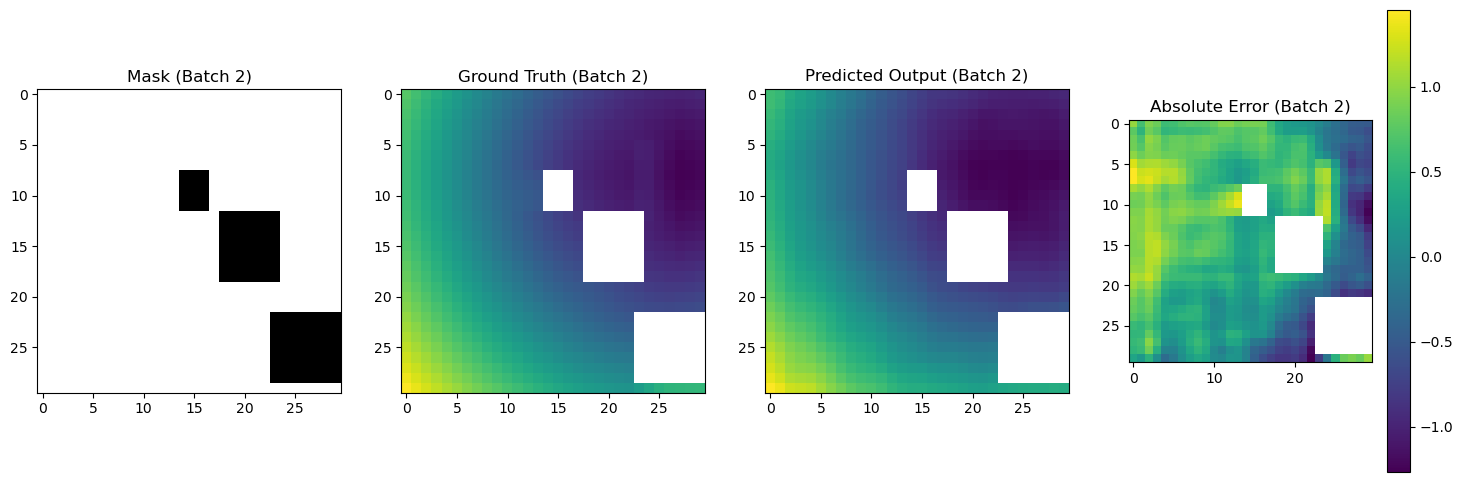

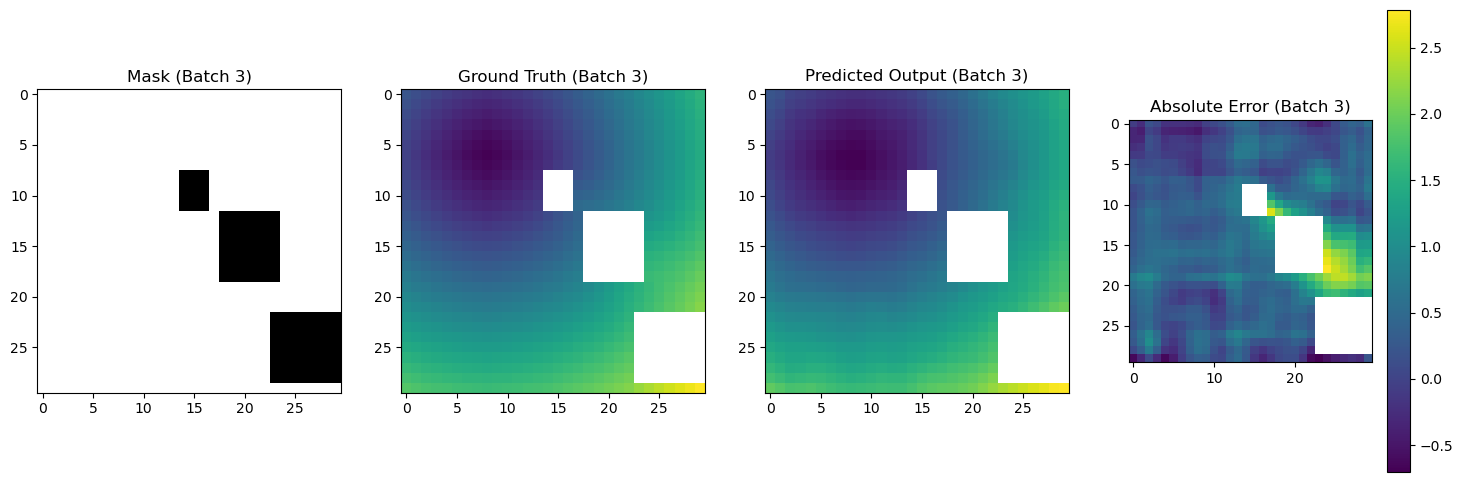

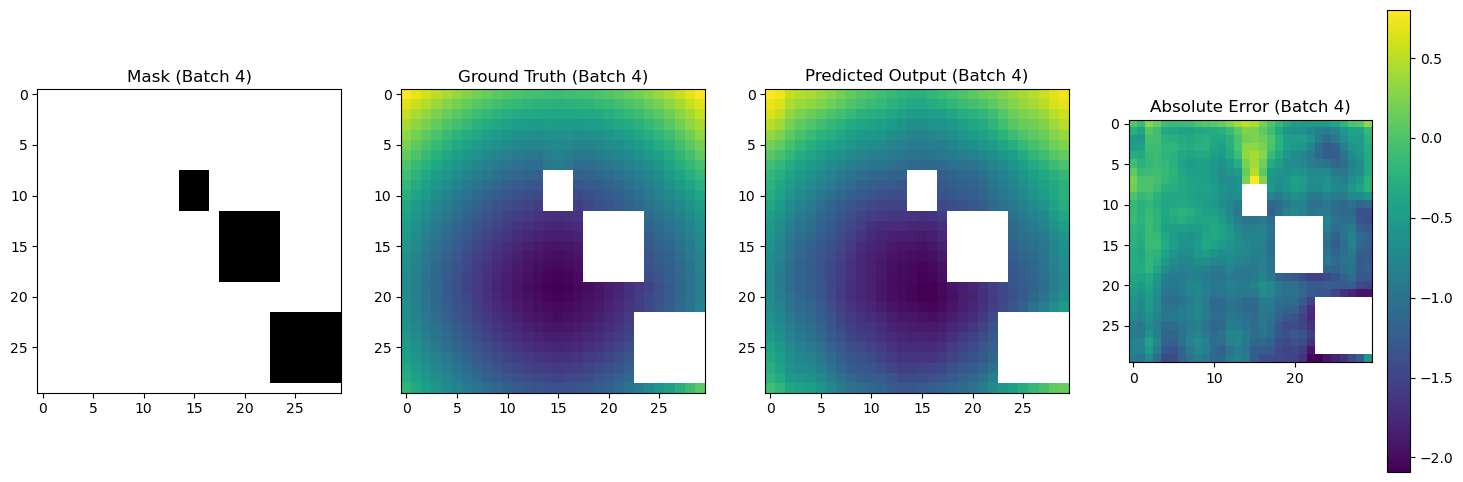

In [4]:
# Compare Ground Truth and Predicted Values for a couple of cross-sections of maps
z = 20  #Adjust Z set level

mean_error = 0
count = 0
normalization = 1/1.0  # Adjust or calculate as needed

with torch.no_grad():
    for batch_id, (mask, chi, ground_truth, gg) in enumerate(test_loader):
        mask, chi, ground_truth, gg = mask.to(device), chi.to(device), ground_truth.to(device), gg.to(device)
        predicted_output = model(chi, gg)
        predicted_output = torch.where(mask == 0, torch.tensor(float('inf')), predicted_output) 
        ground_truth = torch.where(mask == 0, torch.tensor(float('inf')), ground_truth)
        absolute_error = (ground_truth - predicted_output * normalization)
        if batch_id == 5:
            break

        # Plot results for the current batch
        plt.figure(figsize=(18, 6))
        
        titles = ['Mask', 'Ground Truth', 'Predicted Output', 'Absolute Error']
        images = [
            mask[0, :, :, z,0].cpu().numpy(),
            ground_truth[0, :, :,z, 0].cpu().numpy(),
            predicted_output[0, :, :,z, 0].cpu().numpy(),
            absolute_error[0, :, :,z, 0].cpu().numpy()
        ]
        for i in range(4):
            plt.subplot(1, 4, i+1)
            plt.imshow(images[i], cmap='viridis' if i > 0 else 'gray')
            plt.title(f'{titles[i]} (Batch {batch_id})')
            if i == 3:
                plt.colorbar()
        plt.show()

In [5]:
#Gradient Descent Function

# Primary movements in 3D: forward, backward, left, right, up, down
primary_moves = [
    [-1., 0., 0.],  # left
    [1., 0., 0.],   # right
    [0., 1., 0.],   # forward
    [0., -1., 0.],  # backward
    [0., 0., 1.],   # up
    [0., 0., -1.]   # down
]

# Diagonal movements in 3D
diagonal_moves = [
    [-1., 1., 0.],  # left-forward
    [-1., -1., 0.], # left-backward
    [1., 1., 0.],   # right-forward
    [1., -1., 0.],  # right-backward
    [-1., 0., 1.],  # left-up
    [-1., 0., -1.], # left-down
    [1., 0., 1.],   # right-up
    [1., 0., -1.],  # right-down
    [0., 1., 1.],   # forward-up
    [0., 1., -1.],  # forward-down
    [0., -1., 1.],  # backward-up
    [0., -1., -1.], # backward-down
    [-1., 1., 1.],  # left-forward-up
    [-1., 1., -1.], # left-forward-down
    [-1., -1., 1.], # left-backward-up
    [-1., -1., -1.],# left-backward-down
    [1., 1., 1.],   # right-forward-up
    [1., 1., -1.],  # right-forward-down
    [1., -1., 1.],  # right-backward-up
    [1., -1., -1.]  # right-backward-down
]

# Combine primary and diagonal moves
action_vecs = np.asarray(primary_moves + diagonal_moves)

def perform_gradient_descent(value_function, start_point, goal_point, plotsuccess=False, plotfails=False, learning_rate=1, num_steps=1000):
    # print("Start Position:",start_point)
    # print("Goal Position:", goal_point)
    path_length = 0
    path_points = [start_point.copy().astype(float)]
    visited_points = set()
    current_point = start_point.copy().astype(float)

    for step in range(num_steps):
        best_gradient = np.inf
        best_action = None

        for action in action_vecs:
            new_point = current_point + learning_rate * action
            new_point_indices = np.round(new_point).astype(int)
            x_index, y_index, z_index = new_point_indices

            if (0 <= x_index < value_function.shape[0] and 
                0 <= y_index < value_function.shape[1] and 
                0 <= z_index < value_function.shape[2] and 
                (x_index, y_index, z_index) not in visited_points):
                gradient = value_function[x_index, y_index, z_index]
                if gradient < best_gradient:
                    best_gradient = gradient
                    best_action = action

        if best_gradient > 100:
            if plotfails:
                print("Failed Path:")
                plot_path(value_function, path_points)
            return False, 0  

        if best_action is not None:
            current_point += learning_rate * best_action
            path_length += np.linalg.norm(learning_rate * best_action)
            path_points.append(current_point.copy())
            visited_points.add(tuple(np.round(current_point).astype(int)))
            if np.array_equal(np.round(current_point).astype(int), np.round(goal_point).astype(int)):
                if plotsuccess:
                    print("Successful Path:")
                    plot_path(value_function, path_points)
                return True, path_length  # Success
        else:
            if plotfails:
                print("Failed Path:")
                plot_path(value_function, path_points)
            return False, 0  # No valid action found
    if plotfails:
        print("Failed Path:")
        plot_path(value_function, path_points)
    return False, 0  

def plot_path(value_function, path_points):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    path_points = np.array(path_points)

    # Identify and plot points where value function is infinite
    inf_indices = np.where(np.isinf(value_function))
    ax.scatter(inf_indices[0], inf_indices[1], inf_indices[2], c='k', marker='o', label='Obstacles')

    # Plot the path
    ax.plot(path_points[:, 0], path_points[:, 1], path_points[:, 2], 'ro-', label='Path')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.show()



In [6]:
# Compare against classical Planners

nosuceesscount = 0
notime = 0
nopath = 0

astarsuccesscount = 0
astartime = 0
astarpath = 0

with torch.no_grad():
    for batch_id, (mask, chi, ground_truth, gg) in enumerate(test_loader):
        mask, chi, ground_truth, gg = mask.to(device)[0,:,:,:,0].reshape(1,30,30,30,1), chi.to(device)[0,:,:,:,0].reshape(1,30,30,30,1), ground_truth.to(device)[0,:,:,:,0].reshape(1,30,30,30,1), gg.to(device)[0,:,0].reshape(1,3,1)
        goal_point = gg[0,:,0].cpu().numpy()
        start_point = np.array([0,0,0])
        
        # Neural Operator Planning
        t1 = tic()
        predicted_output = model(chi, gg)
        predicted_output = torch.where(mask == 0, torch.tensor(float('inf')), predicted_output)
        value_function = predicted_output[0, :, :, :, 0].cpu().detach().numpy()
        success, pathlength = perform_gradient_descent(value_function,start_point,goal_point)
        dt = toc(t1)

        if(success):
            nosuceesscount+=1
            notime+=dt
            nopath+=pathlength

        cmap =  1-mask.squeeze().cpu().detach().numpy()
        goal_coord = goal_point
        start_coord = start_point
        env = Environment3D(goal_coord,cmap)

        # A* Planning
        t1 = tic()
        path_cost, path, action_idx = AStar.plan(start_coord, env)
        dt = toc(t1)

        if(path_cost < np.inf):
            astarsuccesscount+=1
            astartime+=dt
            astarpath+=path_cost

        #RRT* Planning


      

print("A* success rate",(astarsuccesscount/(batch_id+1)),"A* avg time",(astartime/astarsuccesscount),"A* pathcost",(astarpath/astarsuccesscount))
# print("RRT* success rate",(nosuceesscount/(batch_id+1)), "RRT* avg time",(notime/nosuceesscount),    "RRT* pathcost",(nopath/nosuceesscount))
print("NO success rate",(nosuceesscount/(batch_id+1)),   "NO avg time",(notime/nosuceesscount),      "NO pathcost",(nopath/nosuceesscount))


A* success rate 1.0 A* avg time 0.10969300007820129 A* pathcost 30.54816231672353
NO success rate 1.0 NO avg time 0.017285871267318724 NO pathcost 31.96807178549899
